In [1]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt
import openmc_source_plotter
import plotly.graph_objects as go
from math import cos, pi

In [3]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

In [16]:
#ground surface
ground_surface = openmc.model.RectangularParallelepiped(0, 50000, -10, 0, -1000, 0)
ground_region = -ground_surface
ground_cell = openmc.Cell(region=ground_region, fill=ground_material)

#air surface - 0-500m in x and 0.1m in y and a height of 1000m
air_lower_left = [0, -10,0]
air_upper_right = [50000, 0,100000]
#reflective boundary conditions for min x min y and max y to show symmetry
xmin_box = openmc.XPlane(x0=air_lower_left[0], boundary_type = 'reflective')
xmax_box = openmc.XPlane(x0=air_upper_right[0],boundary_type = 'vacuum')
ymin_box = openmc.YPlane(y0=air_lower_left[1],boundary_type = 'reflective')
ymax_box = openmc.YPlane(y0=air_upper_right[1], boundary_type='reflective')
zmin_box = openmc.ZPlane(z0=air_lower_left[2],boundary_type = 'vacuum')
zmax_box = openmc.ZPlane(z0=air_upper_right[2], boundary_type='vacuum')

air_region =  +ymin_box & -ymax_box & +xmin_box & -xmax_box & +zmin_box & -xmax_box
air_cell = openmc.Cell(region=air_region, fill=air)

#void
xmin = openmc.XPlane(x0=-10, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=50010, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-20, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=10, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-1001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=100010, boundary_type = 'vacuum')
whole_region = +xmin & -xmax & -ymax & +ymin & -zmax & +zmin
void = whole_region & ~ground_region & ~air_region
void_cell =  openmc.Cell(region=void)

In [31]:
universe = openmc.Universe(cells=[void_cell, ground_cell, air_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()

In [32]:
num_particles = 1000000
#create the source
sett = openmc.Settings()
sett.particles = num_particles
sett.batches = 4
sett.inactive = 0
sett.run_mode = 'fixed source'

source = openmc.Source()
source.particle = 'neutron'
source.energy = openmc.stats.Discrete([19e6], [1])

mu = openmc.stats.Uniform(cos(pi/5), 1.0)
phi = openmc.stats.Uniform(0.0, 2*pi)
source.angle  = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(0, 0., 1))
source.space = openmc.stats.Point((0,0,5000))
sett.source = source
    
#%matplotlib inline
#plot = source.plot_source_direction()
#plot.show()
sett.export_to_xml()


In [25]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [500,1,1]
air_mesh.lower_left = [0,-10, 0]

air_mesh.upper_right = [50000,0, 100]

mesh_filter = openmc.MeshFilter(air_mesh)

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning:

Another MeshBase instance already exists with id=1.



In [20]:
#tally for flux 
neutron_particle_filter = openmc.ParticleFilter(['neutron'])
tallies = openmc.Tallies()
shine_dose_tally = openmc.Tally(name='shine_dose_tally')
shine_dose_tally.scores  = ['flux']
shine_dose_tally.filters = [mesh_filter, neutron_particle_filter]
tallies.append(shine_dose_tally)
tallies.export_to_xml()

In [23]:
#look at current through mesh surface
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(
    particle='neutron', geometry='AP')
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
surf_mesh_filter = openmc.MeshSurfaceFilter(air_mesh)
mesh_current_tally = openmc.Tally(name='mesh_current_tally')
mesh_current_tally.scores = ['current']
mesh_current_tally.filters = [surf_mesh_filter, neutron_particle_filter]
tallies.append(mesh_current_tally)

In [33]:
model = openmc.model.Model(geom, mats, sett, tallies)
!rm *.h5
results_filename = model.run(threads=8)
    
results = openmc.StatePoint(results_filename)
#get flux and current tallies
flux_tally = results.get_tally(name="shine_dose_tally")
curr_tally = results.get_tally(name="mesh_current_tally")

results.close()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [38]:
df_dose = flux_tally.get_pandas_dataframe()
df_curr = curr_tally.get_pandas_dataframe()

array([[[[ 0.00e+00, -1.00e+01,  0.00e+00],
         [ 0.00e+00, -1.00e+01,  1.00e+02]],

        [[ 0.00e+00,  0.00e+00,  0.00e+00],
         [ 0.00e+00,  0.00e+00,  1.00e+02]]],


       [[[ 1.00e+02, -1.00e+01,  0.00e+00],
         [ 1.00e+02, -1.00e+01,  1.00e+02]],

        [[ 1.00e+02,  0.00e+00,  0.00e+00],
         [ 1.00e+02,  0.00e+00,  1.00e+02]]],


       [[[ 2.00e+02, -1.00e+01,  0.00e+00],
         [ 2.00e+02, -1.00e+01,  1.00e+02]],

        [[ 2.00e+02,  0.00e+00,  0.00e+00],
         [ 2.00e+02,  0.00e+00,  1.00e+02]]],


       ...,


       [[[ 4.98e+04, -1.00e+01,  0.00e+00],
         [ 4.98e+04, -1.00e+01,  1.00e+02]],

        [[ 4.98e+04,  0.00e+00,  0.00e+00],
         [ 4.98e+04,  0.00e+00,  1.00e+02]]],


       [[[ 4.99e+04, -1.00e+01,  0.00e+00],
         [ 4.99e+04, -1.00e+01,  1.00e+02]],

        [[ 4.99e+04,  0.00e+00,  0.00e+00],
         [ 4.99e+04,  0.00e+00,  1.00e+02]]],


       [[[ 5.00e+04, -1.00e+01,  0.00e+00],
         [ 5.00e+04, -1.00e+01, 

In [39]:
mesh_vol = 50*100*10
distance_x = air_mesh.vertices[:,0,0,0]
distance_x

array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
         800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
        1600.,  1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,
        2400.,  2500.,  2600.,  2700.,  2800.,  2900.,  3000.,  3100.,
        3200.,  3300.,  3400.,  3500.,  3600.,  3700.,  3800.,  3900.,
        4000.,  4100.,  4200.,  4300.,  4400.,  4500.,  4600.,  4700.,
        4800.,  4900.,  5000.,  5100.,  5200.,  5300.,  5400.,  5500.,
        5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,  6300.,
        6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,
        7200.,  7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,
        8000.,  8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,
        8800.,  8900.,  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,
        9600.,  9700.,  9800.,  9900., 10000., 10100., 10200., 10300.,
       10400., 10500., 10600., 10700., 10800., 10900., 11000., 11100.,
      

In [41]:
df_dose

mesh 1       particle nuclide score     mean std. dev.
         x  y  z                                          
0        1  1  1  neutron   total  flux 2.97e-01  1.18e-02
1        2  1  1  neutron   total  flux 2.98e-01  7.46e-03
2        3  1  1  neutron   total  flux 2.90e-01  4.90e-03
3        4  1  1  neutron   total  flux 2.82e-01  9.62e-03
4        5  1  1  neutron   total  flux 2.81e-01  1.54e-02
..     ... .. ..      ...     ...   ...      ...       ...
495    496  1  1  neutron   total  flux 2.58e-04  2.58e-04
496    497  1  1  neutron   total  flux 0.00e+00  0.00e+00
497    498  1  1  neutron   total  flux 0.00e+00  0.00e+00
498    499  1  1  neutron   total  flux 0.00e+00  0.00e+00
499    500  1  1  neutron   total  flux 0.00e+00  0.00e+00

[500 rows x 8 columns]

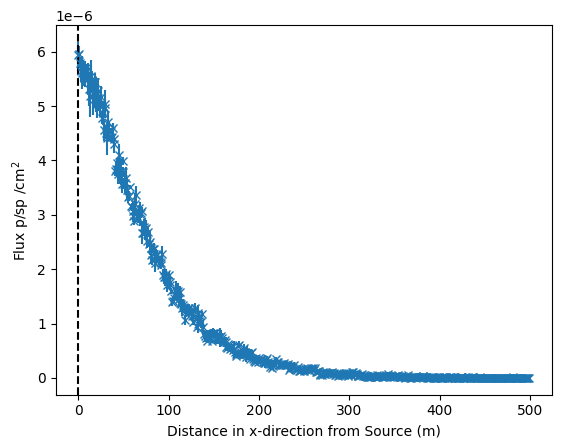

In [42]:
flux = df_dose[df_dose['score'] == 'flux']
flux_mean = (flux["mean"] / mesh_vol)
flux_std = (flux["std. dev."] / mesh_vol) 
plt.errorbar(distance_x[:-1]/100, flux_mean, flux_std, ls='None', marker='x')
plt.xlabel("Distance in x-direction from Source (m)")
plt.ylabel("Flux p/sp /cm$^2$ ")
plt.axvline(x=0, ls='--', color='black')

#plt.yscale('log')

#plot flux as function of energy
flux_array = np.array(flux_list)
flux_array
np.max(df_list[0]["mean"])

In [43]:
curr = df_curr[df_curr['score'] == 'current']
curr = curr[curr['mesh 1']['surf'] == 'z-max in']
curr_mean = curr['mean']
curr_std = curr['std. dev.']
curr           
#want z max in - max particles coming in from top of mesh

mesh 1                 particle nuclide    score      mean std. dev.
          x  y  z      surf                                              
11        1  1  1  z-max in  neutron   total  current  0.001693  0.000066
23        2  1  1  z-max in  neutron   total  current  0.001778  0.000039
35        3  1  1  z-max in  neutron   total  current  0.001660  0.000054
47        4  1  1  z-max in  neutron   total  current  0.001738  0.000096
59        5  1  1  z-max in  neutron   total  current  0.001653  0.000027
...     ... .. ..       ...      ...     ...      ...       ...       ...
5951    496  1  1  z-max in  neutron   total  current  0.000003  0.000003
5963    497  1  1  z-max in  neutron   total  current  0.000000  0.000000
5975    498  1  1  z-max in  neutron   total  current  0.000000  0.000000
5987    499  1  1  z-max in  neutron   total  current  0.000000  0.000000
5999    500  1  1  z-max in  neutron   total  current  0.000000  0.000000

[500 rows x 9 columns]

Text(0, 0.5, 'particles going into mesh from above z')

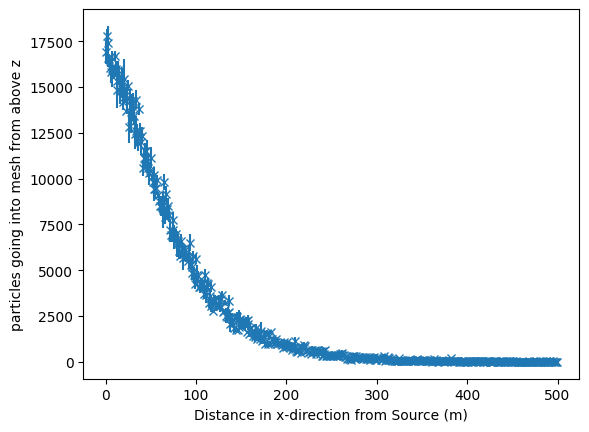

In [44]:
norm_curr_mean = 1e7 * curr_mean
norm_curr_std = 1e7 * curr_std
plt.errorbar(distance_x[:-1]/100, norm_curr_mean, norm_curr_std, ls='None', marker='x')
plt.xlabel("Distance in x-direction from Source (m)")
plt.ylabel("particles going into mesh from above z")

In [45]:
total = norm_curr_mean.cumsum().iloc[-1]
total

1356350.0

In [46]:
percent_reach_bott = total/1e7
print("The percentage of particles reaching the bottom mesh surface is " + str(percent_reach_bott*100) + " %")

The percentage of particles reaching the bottom mesh surface is 13.563500000000001 %
